In [134]:
import deepdish as dd
import os
import numpy as np
import pylab as plt

In [117]:
python = '/Users/gravity/opt/anaconda3/envs/gwforge_18Oct24/bin/python'

In [139]:
test_data_local = dd.io.load('../output_data/1_day_prec_z_10_local_SNR_data.h5')['Optimal_SNR']
test_data_parallel = dd.io.load('../output_data/1_day_prec_z_10_parallel_SNR_data.h5')['Optimal_SNR']
test_data_serial = dd.io.load('../output_data/1_day_prec_z_10_serial_SNR_data.h5')['Optimal_SNR']

In [140]:
test_data.keys()

Index(['inclination', 'distance', 'mass1', 'mass2', 'coa_phase', 'f_ref',
       'spin1x', 'spin1y', 'spin1z', 'spin2x', 'spin2y', 'spin2z',
       'approximant', 'f_lower', 'delta_f', 'f_final', 'dec', 'trigger_time',
       'polarization', 'ra', 'SNR_L1', 'SNR_H1', 'SNR_V1', 'SNR_network_sq',
       'SNR_network'],
      dtype='object')

In [141]:
def get_detected_SNRs(data_dict, ifo_threshold=8, network_threshold=10):
    detected = {}
    SNR_keys = [key for key in data_dict.keys() if 'SNR' in key]
    for key in SNR_keys:
        if "network_sq" in key:
            detected[key.split('SNR_')[-1]] = data_dict[data_dict[key] > network_threshold**2]
        elif "network" in key:
            detected[key.split('SNR_')[-1]] = data_dict[data_dict[key] > network_threshold]
        else:
            detected[key.split('SNR_')[-1]] = data_dict[data_dict[key] > ifo_threshold]
    return(detected)

In [142]:
get_detected_SNRs(test_data_local)['network']

,inclination,distance,mass1,mass2,coa_phase,f_ref,spin1x,spin1y,spin1z,spin2x,...,f_final,dec,trigger_time,polarization,ra,SNR_L1,SNR_H1,SNR_V1,SNR_network_sq,SNR_network
34,0.532770,2810.675418,47.076243,29.655835,5.629477,5.0,0.274178,0.838540,-0.230261,-0.238946,...,1567,-0.698742,1.893034e+09,0.619728,5.490057,6.509596,6.353447,8.570054,156.186957,12.497478
235,1.447689,1803.846948,59.656395,53.806263,1.258496,5.0,-0.024972,0.020333,0.086569,0.293121,...,1567,-0.664756,1.893088e+09,0.007347,3.332223,3.096475,5.307420,10.937706,157.390280,12.545528


In [143]:
test_data_local

,inclination,distance,mass1,mass2,coa_phase,f_ref,spin1x,spin1y,spin1z,spin2x,...,f_final,dec,trigger_time,polarization,ra,SNR_L1,SNR_H1,SNR_V1,SNR_network_sq,SNR_network
0,2.044218,15910.177234,24.067184,20.678905,5.857329,5.0,0.351706,0.607847,0.269369,0.204981,...,1567,-0.275366,1.893024e+09,0.389202,4.715751,0.487512,0.533757,0.590502,0.871258,0.933412
1,0.814655,86494.483545,120.322944,46.078525,4.599534,5.0,-0.153557,-0.018616,0.084814,-0.002927,...,1567,0.619913,1.893024e+09,0.577598,5.685129,0.476777,0.581325,0.040059,0.566860,0.752901
2,0.854060,11658.849526,98.273412,90.179451,0.806561,5.0,-0.390056,0.770851,0.360586,-0.567327,...,1567,-0.134277,1.893024e+09,2.466339,2.557177,4.499548,4.632075,2.476930,47.837235,6.916447
3,1.824899,21357.994493,26.416732,22.714079,5.415277,5.0,-0.116564,0.070595,0.017128,-0.126201,...,1567,1.311096,1.893024e+09,1.300400,4.519011,0.425000,0.595036,0.383255,0.681577,0.825577
4,2.096056,23702.104440,33.869181,15.898584,0.559625,5.0,-0.051949,0.314967,0.153816,-0.147587,...,1567,-0.468409,1.893025e+09,0.533195,3.522029,0.754944,0.618900,0.310380,1.049314,1.024361
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
303,0.431555,35060.675516,43.462251,36.899170,2.715863,5.0,0.324374,-0.276009,0.688752,0.020310,...,1567,-0.289356,1.893108e+09,0.126436,1.559662,0.398682,0.871713,0.740558,1.467257,1.211304
304,1.672693,40544.897033,53.174884,36.367374,1.223224,5.0,0.647683,-0.583094,0.424733,0.001290,...,1567,1.267413,1.893108e+09,2.255736,0.044369,0.436357,0.443518,0.168097,0.415372,0.644494
305,1.807979,19271.132730,149.120227,138.449877,2.393262,5.0,-0.264450,0.057476,0.512947,0.024528,...,1567,-0.342076,1.893109e+09,1.315998,4.243606,2.777699,1.552195,2.071062,14.414220,3.796606
306,1.544522,21156.057514,46.462256,37.488529,2.268530,5.0,-0.235932,-0.008022,0.679210,0.025989,...,1567,0.271812,1.893109e+09,2.807458,3.491457,0.376169,0.094786,0.203502,0.191901,0.438065


In [144]:
test_data_serial

,inclination,distance,mass1,mass2,coa_phase,f_ref,spin1x,spin1y,spin1z,spin2x,...,f_final,dec,trigger_time,polarization,ra,SNR_L1,SNR_H1,SNR_V1,SNR_network_sq,SNR_network
0,2.044218,15910.177234,24.067184,20.678905,5.857329,5.0,0.351706,0.607847,0.269369,0.204981,...,1567,-0.275366,1.893024e+09,0.389202,4.715751,0.487512,0.533757,0.590502,0.871258,0.933412
1,0.814655,86494.483545,120.322944,46.078525,4.599534,5.0,-0.153557,-0.018616,0.084814,-0.002927,...,1567,0.619913,1.893024e+09,0.577598,5.685129,0.476777,0.581325,0.040059,0.566860,0.752901
2,0.854060,11658.849526,98.273412,90.179451,0.806561,5.0,-0.390056,0.770851,0.360586,-0.567327,...,1567,-0.134277,1.893024e+09,2.466339,2.557177,4.499548,4.632075,2.476930,47.837236,6.916447
3,1.824899,21357.994493,26.416732,22.714079,5.415277,5.0,-0.116564,0.070595,0.017128,-0.126201,...,1567,1.311096,1.893024e+09,1.300400,4.519011,0.425000,0.595036,0.383255,0.681577,0.825577
4,2.096056,23702.104440,33.869181,15.898584,0.559625,5.0,-0.051949,0.314967,0.153816,-0.147587,...,1567,-0.468409,1.893025e+09,0.533195,3.522029,0.754944,0.618900,0.310380,1.277110,1.130093
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
303,0.431555,35060.675516,43.462251,36.899170,2.715863,5.0,0.324374,-0.276009,0.688752,0.020310,...,1567,-0.289356,1.893108e+09,0.126436,1.559662,0.398682,0.871713,0.740558,35062.142773,187.248879
304,1.672693,40544.897033,53.174884,36.367374,1.223224,5.0,0.647683,-0.583094,0.424733,0.001290,...,1567,1.267413,1.893108e+09,2.255736,0.044369,0.436357,0.443518,0.168097,40545.312406,201.358666
305,1.807979,19271.132730,149.120227,138.449877,2.393262,5.0,-0.264450,0.057476,0.512947,0.024528,...,1567,-0.342076,1.893109e+09,1.315998,4.243606,2.777699,1.552195,2.071062,19285.546950,138.872412
306,1.544522,21156.057514,46.462256,37.488529,2.268530,5.0,-0.235932,-0.008022,0.679210,0.025989,...,1567,0.271812,1.893109e+09,2.807458,3.491457,0.376169,0.094786,0.203502,21156.249415,145.451880


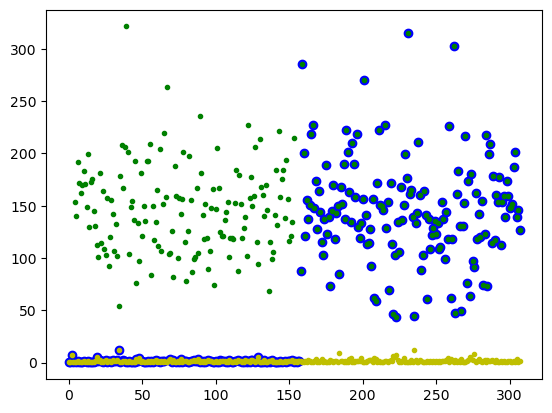

In [151]:
plt.plot(test_data_serial['SNR_network'], 'bo')
plt.plot(test_data_parallel['SNR_network'], 'g.')
plt.plot(test_data_local['SNR_network'], 'y.')

In [133]:
test_data_parallel

,inclination,distance,mass1,mass2,coa_phase,f_ref,spin1x,spin1y,spin1z,spin2x,...,f_final,dec,trigger_time,polarization,ra,SNR_L1,SNR_H1,SNR_V1,SNR_network_sq,SNR_network
0,2.044218,15910.177234,24.067184,20.678905,5.857329,5.0,0.351706,0.607847,0.269369,0.204981,...,1567,-0.275366,1.893024e+09,0.389202,4.715751,0.487512,0.533757,0.590502,0.871258,0.933412
1,0.814655,86494.483545,120.322944,46.078525,4.599534,5.0,-0.153557,-0.018616,0.084814,-0.002927,...,1567,0.619913,1.893024e+09,0.577598,5.685129,0.476777,0.581325,0.040059,0.566860,0.752901
2,0.854060,11658.849526,98.273412,90.179451,0.806561,5.0,-0.390056,0.770851,0.360586,-0.567327,...,1567,-0.134277,1.893024e+09,2.466339,2.557177,4.499548,4.632075,2.476930,47.837236,6.916447
3,1.824899,21357.994493,26.416732,22.714079,5.415277,5.0,-0.116564,0.070595,0.017128,-0.126201,...,1567,1.311096,1.893024e+09,1.300400,4.519011,0.425000,0.595036,0.383255,0.681577,0.825577
4,2.096056,23702.104440,33.869181,15.898584,0.559625,5.0,-0.051949,0.314967,0.153816,-0.147587,...,1567,-0.468409,1.893025e+09,0.533195,3.522029,0.754944,0.618900,0.310380,23703.153754,153.958286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
303,0.431555,35060.675516,43.462251,36.899170,2.715863,5.0,0.324374,-0.276009,0.688752,0.020310,...,1567,-0.289356,1.893108e+09,0.126436,1.559662,0.398682,0.871713,0.740558,35062.142773,187.248879
304,1.672693,40544.897033,53.174884,36.367374,1.223224,5.0,0.647683,-0.583094,0.424733,0.001290,...,1567,1.267413,1.893108e+09,2.255736,0.044369,0.436357,0.443518,0.168097,40545.312406,201.358666
305,1.807979,19271.132730,149.120227,138.449877,2.393262,5.0,-0.264450,0.057476,0.512947,0.024528,...,1567,-0.342076,1.893109e+09,1.315998,4.243606,2.777699,1.552195,2.071062,19285.546950,138.872412
306,1.544522,21156.057514,46.462256,37.488529,2.268530,5.0,-0.235932,-0.008022,0.679210,0.025989,...,1567,0.271812,1.893109e+09,2.807458,3.491457,0.376169,0.094786,0.203502,21156.249415,145.451880


In [111]:
get_detected_SNRs(test_data_parallel)['network']

,inclination,distance,mass1,mass2,coa_phase,f_ref,spin1x,spin1y,spin1z,spin2x,...,f_final,dec,trigger_time,polarization,ra,SNR_L1,SNR_H1,SNR_V1,SNR_network_sq,SNR_network
235,1.447689,1803.846948,59.656395,53.806263,1.258496,5.0,-0.024972,0.020333,0.086569,0.293121,...,1567,-0.664756,1.893088e+09,0.007347,3.332223,3.096476,5.30742,10.937706,157.870382,12.564648


In [110]:
get_detected_SNRs(test_data_serial)['network']

,inclination,distance,mass1,mass2,coa_phase,f_ref,spin1x,spin1y,spin1z,spin2x,...,f_final,dec,trigger_time,polarization,ra,SNR_L1,SNR_H1,SNR_V1,SNR_network_sq,SNR_network
34,0.532770,2810.675418,47.076243,29.655835,5.629477,5.0,0.274178,0.838540,-0.230261,-0.238946,...,1567,-0.698742,1.893034e+09,0.619728,5.490057,6.509596,6.353447,8.570055,156.186961,12.497478
158,0.539057,7725.735632,19.294109,15.396976,4.956534,5.0,0.116759,0.785889,0.009251,-0.142953,...,1567,0.274116,1.893064e+09,1.507505,1.273265,0.384384,1.162232,1.271125,7728.849925,87.913878
159,1.862996,81632.420598,73.515562,70.220650,4.383972,5.0,0.209414,0.062967,-0.055276,-0.051478,...,1567,-0.907480,1.893064e+09,0.654085,1.450033,0.216859,0.261069,0.216716,81632.582748,285.714163
160,2.143355,40011.260686,49.079957,44.694531,5.144892,5.0,-0.293220,-0.084118,-0.510749,-0.419713,...,1567,0.211291,1.893064e+09,2.042262,5.254377,0.383133,0.325113,0.425053,40011.693845,200.029232
161,2.409255,14706.601989,45.108993,40.652328,5.927392,5.0,0.319072,0.180132,-0.233719,-0.583494,...,1567,0.480645,1.893065e+09,0.548577,0.277539,1.507631,1.209382,0.475246,14710.563405,121.287111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
303,0.431555,35060.675516,43.462251,36.899170,2.715863,5.0,0.324374,-0.276009,0.688752,0.020310,...,1567,-0.289356,1.893108e+09,0.126436,1.559662,0.398682,0.871713,0.740558,35062.142773,187.248879
304,1.672693,40544.897033,53.174884,36.367374,1.223224,5.0,0.647683,-0.583094,0.424733,0.001290,...,1567,1.267413,1.893108e+09,2.255736,0.044369,0.436357,0.443518,0.168097,40545.312406,201.358666
305,1.807979,19271.132730,149.120227,138.449877,2.393262,5.0,-0.264450,0.057476,0.512947,0.024528,...,1567,-0.342076,1.893109e+09,1.315998,4.243606,2.777699,1.552195,2.071062,19285.546950,138.872412
306,1.544522,21156.057514,46.462256,37.488529,2.268530,5.0,-0.235932,-0.008022,0.679210,0.025989,...,1567,0.271812,1.893109e+09,2.807458,3.491457,0.376169,0.094786,0.203502,21156.249415,145.451880


In [77]:
SNRs = {}
detected_SNRs = {}
SNR_threshold = 8
for det in ['L1', 'H1', 'V1', 'network', 'network_sq']:
    
    if det == 'network_sq':
        SNR_threshold = SNR_threshold**2
    SNRs[det] = np.array(test_data['SNR_'+det])
    detected_SNRs[det] = SNRs[det][np.where(SNRs[det] >= SNR_threshold)]

In [78]:
netw_sq = SNRs['H1']**2 + SNRs['L1']**2 + SNRs['V1']**2
for i in range(9):
    print(SNRs['H1'][i]**2 + SNRs['L1'][i]**2 + SNRs['V1'][i]**2, netw_sq[i], SNRs['network_sq'][i])

0.8712575053591547 0.8712575053591547 0.8712575053591547
0.5668601385907314 0.5668601385907314 0.5668601385907314
47.83723459159324 47.83723459159324 47.83723459159324
0.6815772415593295 0.6815772415593295 0.6815772415593295
1.0493144572807556 1.0493144572807556 1.0493144572807556
0.22184313321502608 0.22184313321502608 0.22184313321502608
1.1698793222009567 1.1698793222009567 1.1698793222009567
0.7022796639920941 0.7022796639920941 0.7022796639920941
0.25419825729008233 0.25419825729008233 0.25419825729008233


In [69]:
detected_SNRs

{'L1': array([], dtype=float64),
 'H1': array([], dtype=float64),
 'V1': array([10.93770602]),
 'network': array([12.49747802, 12.54552827]),
 'network_sq': array([156.18695676, 157.39027967])}

In [64]:
detected_SNRs

{'L1': array([], dtype=float64),
 'H1': array([], dtype=float64),
 'V1': array([10.93770617]),
 'network': array([12.56867031]),
 'network_sq': array([157.97147335])}